# Make Figure 1: Model Performance (3-Panel)

Gaylen Fronk  
June 4, 2024

## Setup

In [ ]:
version <- "v6"
cv <- "nested"
y_col_name <- "pp_hybrid_wk4_outcome"

In [ ]:
#| message: false
#| warning: false

# packages for script
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.5      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

In [ ]:
#| message: false
#| warning: false

# handle conflicts
options(conflicts.policy = "depends.ok")

In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- str_c("P:/studydata/match/models/", 
                               y_col_name)
        },
        
        # IOS paths
        Darwin = {
          path_models <- str_c("/Volumes/private/studydata/match/models/",
                               y_col_name)
        },
        
        # Linux paths
        Linux = {
          path_models <- str_c("~/mnt/private/studydata/match/models/",
                               y_col_name)
        }
)

In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)

## Make Panels

### Panel A: ROC Curve

Read in outer loop predictions

In [ ]:
preds_out <- read_rds(file.path(path_models, 
                                str_c("outer_preds_", version, 
                                      "_", cv, ".rds"))) |> 
  glimpse()

Rows: 3,258
Columns: 3
$ outer_split_num <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_raw        <dbl> 0.1909314, 0.4794358, 0.3849448, 0.2902418, 0.3972917,…
$ label           <fct> smoking, smoking, smoking, smoking, abstinent, abstine…

Set up data

In [ ]:
roc_data <- preds_out %>%
  roc_curve(prob_raw, truth = label) |> 
  glimpse()

Rows: 3,260
Columns: 3
$ .threshold  <dbl> -Inf, 0.007374031, 0.010426309, 0.015869775, 0.016545182, …
$ specificity <dbl> 0.0000000000, 0.0000000000, 0.0004662005, 0.0009324009, 0.…
$ sensitivity <dbl> 1.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0000000, 1.0…

Create plot

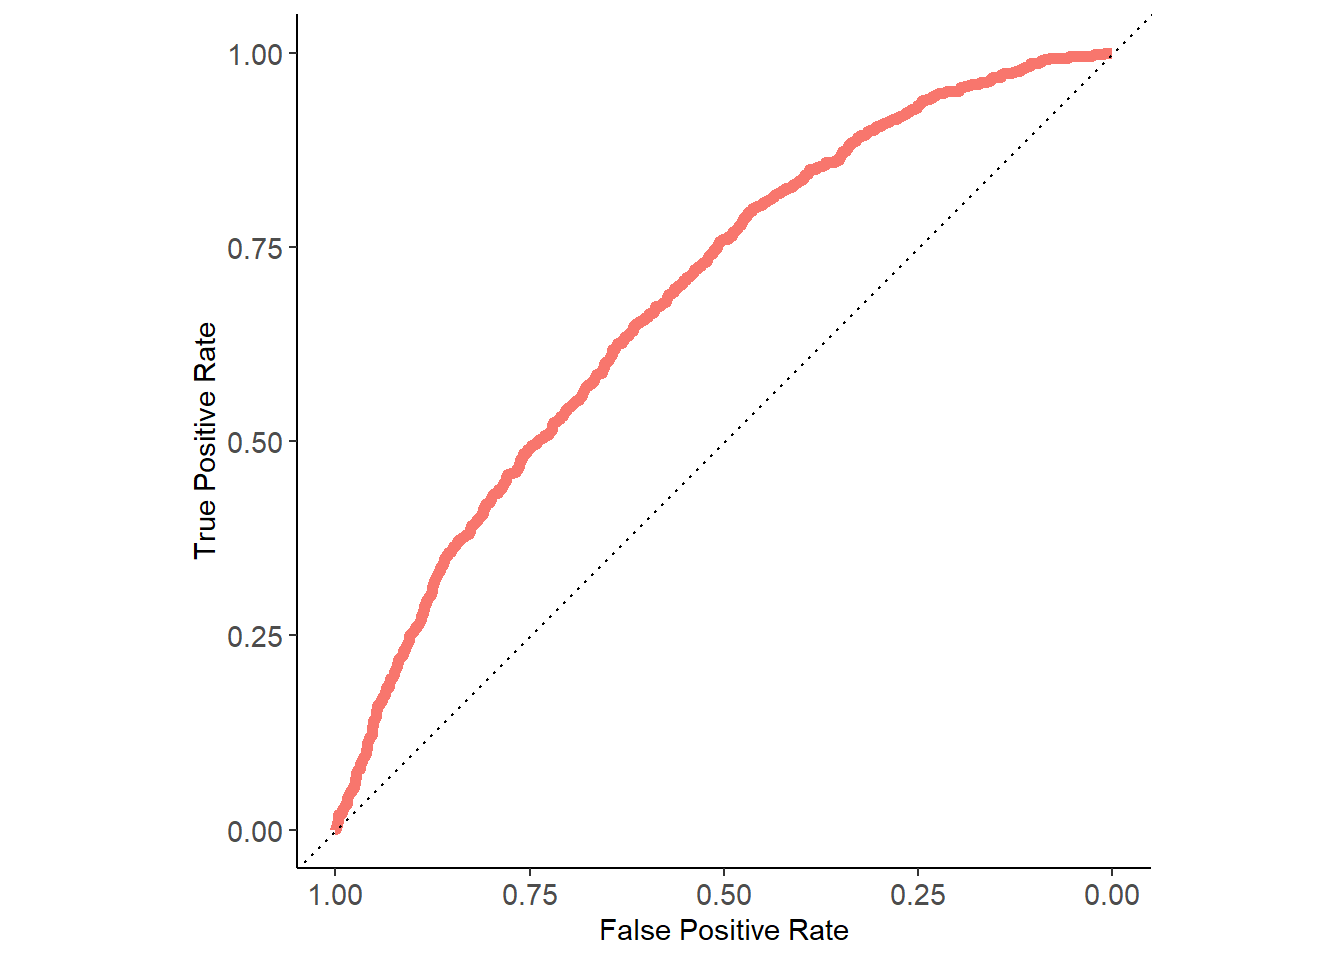

In [ ]:
#| label: fig-roc-single
#| fig-cap: "ROC Curve"

fig_roc <- roc_data %>%
  ggplot(aes(x = 1 - specificity, y = sensitivity, color = "red")) +
  geom_path(linewidth = 2) +
  geom_abline(lty = 3) +
  coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
  labs(x = "False Positive Rate",
       y = "True Positive Rate") +
  scale_x_continuous(breaks = seq(0,1,.25),
                     labels = sprintf("%.2f", seq(1,0,-.25))) +
  theme(axis.text = element_text(size = rel(1)),
        axis.title = element_text(size = rel(1)),
        legend.position = "none")

fig_roc

### Panel B: Posterior Probability Distribution

Read in posteriors

In [ ]:
pp <- read_rds(file.path("P:/studydata/match/models/", 
                         str_c("posteriors_", version, "_nested.rds")))

Set up data

In [ ]:
pp_tidy <- pp |> 
  tidy(seed = 123) |> 
  glimpse()

Rows: 12,000
Columns: 2
$ model     <chr> "week_4", "week_12", "week_26", "week_4", "week_12", "week_2…
$ posterior <dbl> 0.6903614, 0.6647075, 0.6292686, 0.6942714, 0.6666706, 0.610…

Create plot

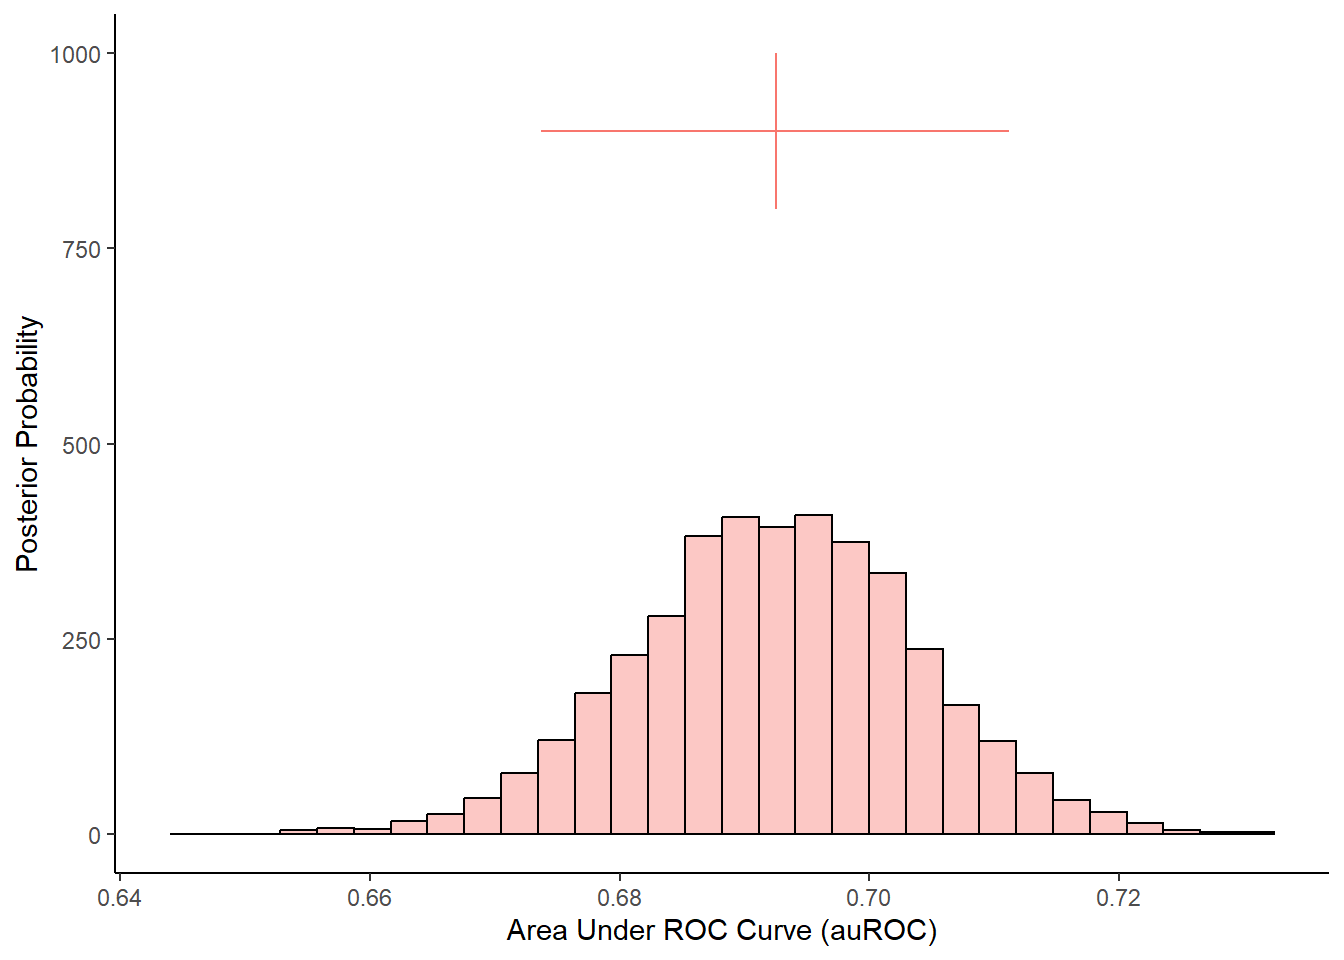

In [ ]:
#| label: fig-pp-wk4
#| fig-cap: "Posterior Probability Distribution"

fig_pp <- pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_12", "week_26"),
                        labels = c("Week 4", "Week 12", "Week 26"))) |> 
  filter(model == "Week 4") |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y, yend = y - 200, x = mean, xend = mean,
                             color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y - 100, yend = y - 100, 
                             x = lower, xend = upper, color = model),
               data = ci) +
  scale_y_continuous("Posterior Probability") +
  labs(
    x = "Area Under ROC Curve (auROC)",
  ) +
  theme(legend.position = "none")

fig_pp

### Panel C: Prediction Calibration

Read in final model predictions (LOOCV)

In [ ]:
d_cal <- read_csv(file.path(path_models,
                            str_c("aim_2_", version, "_", y_col_name, ".csv")),
                  show_col_types = FALSE) |> 
  glimpse()

Rows: 1,086
Columns: 11
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ tx_rct           <chr> "patch", "combo_nrt", "patch", "varenicline", "patch"…
$ tx_best          <chr> "varenicline", "varenicline", "combo_nrt", "varenicli…
$ tx_match         <lgl> FALSE, FALSE, FALSE, TRUE, FALSE, TRUE, FALSE, FALSE,…
$ prob_best        <dbl> 0.2799119, 0.5102584, 0.3089657, 0.4553562, 0.4605510…
$ outcome_rct_wk4  <chr> "smoking", "smoking", "smoking", "smoking", "smoking"…
$ outcome_rct_wk12 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ outcome_rct_wk26 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ prob_patch       <dbl> 0.2080906, 0.4220443, 0.2330746, 0.3961983, 0.3172879…
$ prob_combo_nrt   <dbl> 0.1754414, 0.4957828, 0.3089657, 0.4056079, 0.4605510…
$ prob_varenicline <dbl> 0.2799119, 0.5102584, 0.2883452, 0.4553562, 0.4409814…

Set up data

In [ ]:
d_cal <- d_cal |> 
  mutate(.pred_abstinent = case_when(
    tx_rct == "patch" ~ prob_patch,
    tx_rct == "combo_nrt" ~ prob_combo_nrt,
    tx_rct == "varenicline" ~ prob_varenicline,
    TRUE ~ NA_real_
  )) |> 
  select(outcome_rct = outcome_rct_wk4, .pred_abstinent) |> 
  mutate(outcome_rct = factor(outcome_rct,
                              levels = c("abstinent", "smoking"))) |> 
  glimpse()

Rows: 1,086
Columns: 2
$ outcome_rct     <fct> smoking, smoking, smoking, smoking, smoking, smoking, …
$ .pred_abstinent <dbl> 0.2080906, 0.4957828, 0.2330746, 0.4553562, 0.3172879,…

Created binned plot

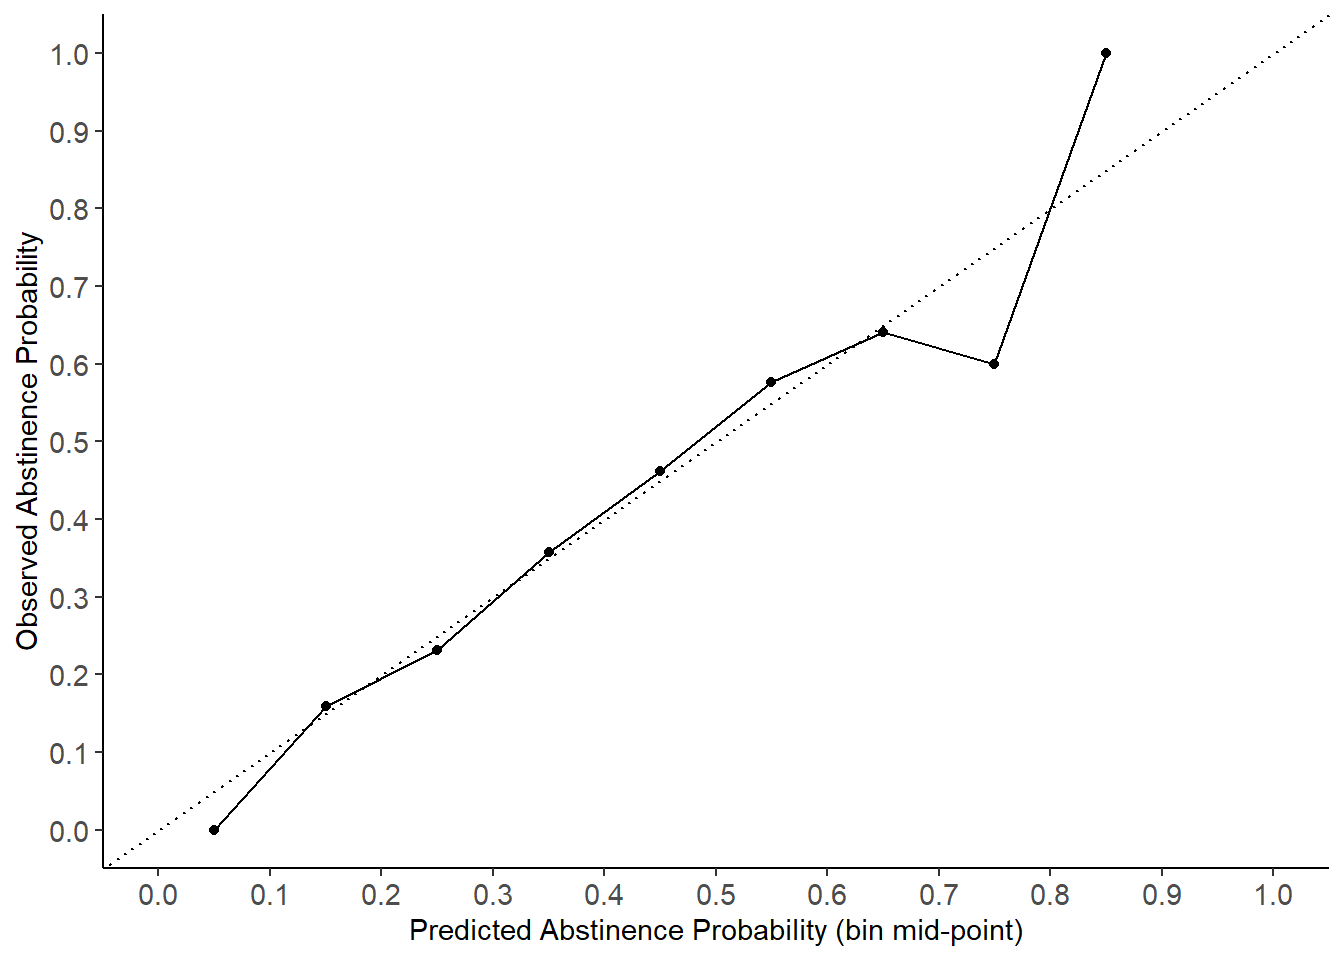

In [ ]:
#| label: fig-cal-bins
#| fig-cap: "Binned Plot"

bin_width = 0.10

fig_cal_bins <- d_cal |> 
  rename(prob_raw = .pred_abstinent) |> 
  mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)),
         abstinent = if_else(outcome_rct == "abstinent", 1, 0)) |> 
  group_by(bins)  |> 
  summarize(mean_abstinent = mean(abstinent),
            .groups = "drop") |>
  mutate(bins = as.numeric(bins),
         midpoints = bin_width/2 + bin_width * (bins - 1))  |> 
  ggplot(data = _, aes(x = midpoints, y = mean_abstinent)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  geom_line() +
  geom_point() +
  xlab("Predicted Abstinence Probability (bin mid-point)") +
  ylab("Observed Abstinence Probability") +
  scale_x_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  theme(axis.text = element_text(size = rel(1)),
        axis.title = element_text(size = rel(1)))

fig_cal_bins

## Combine into single figure

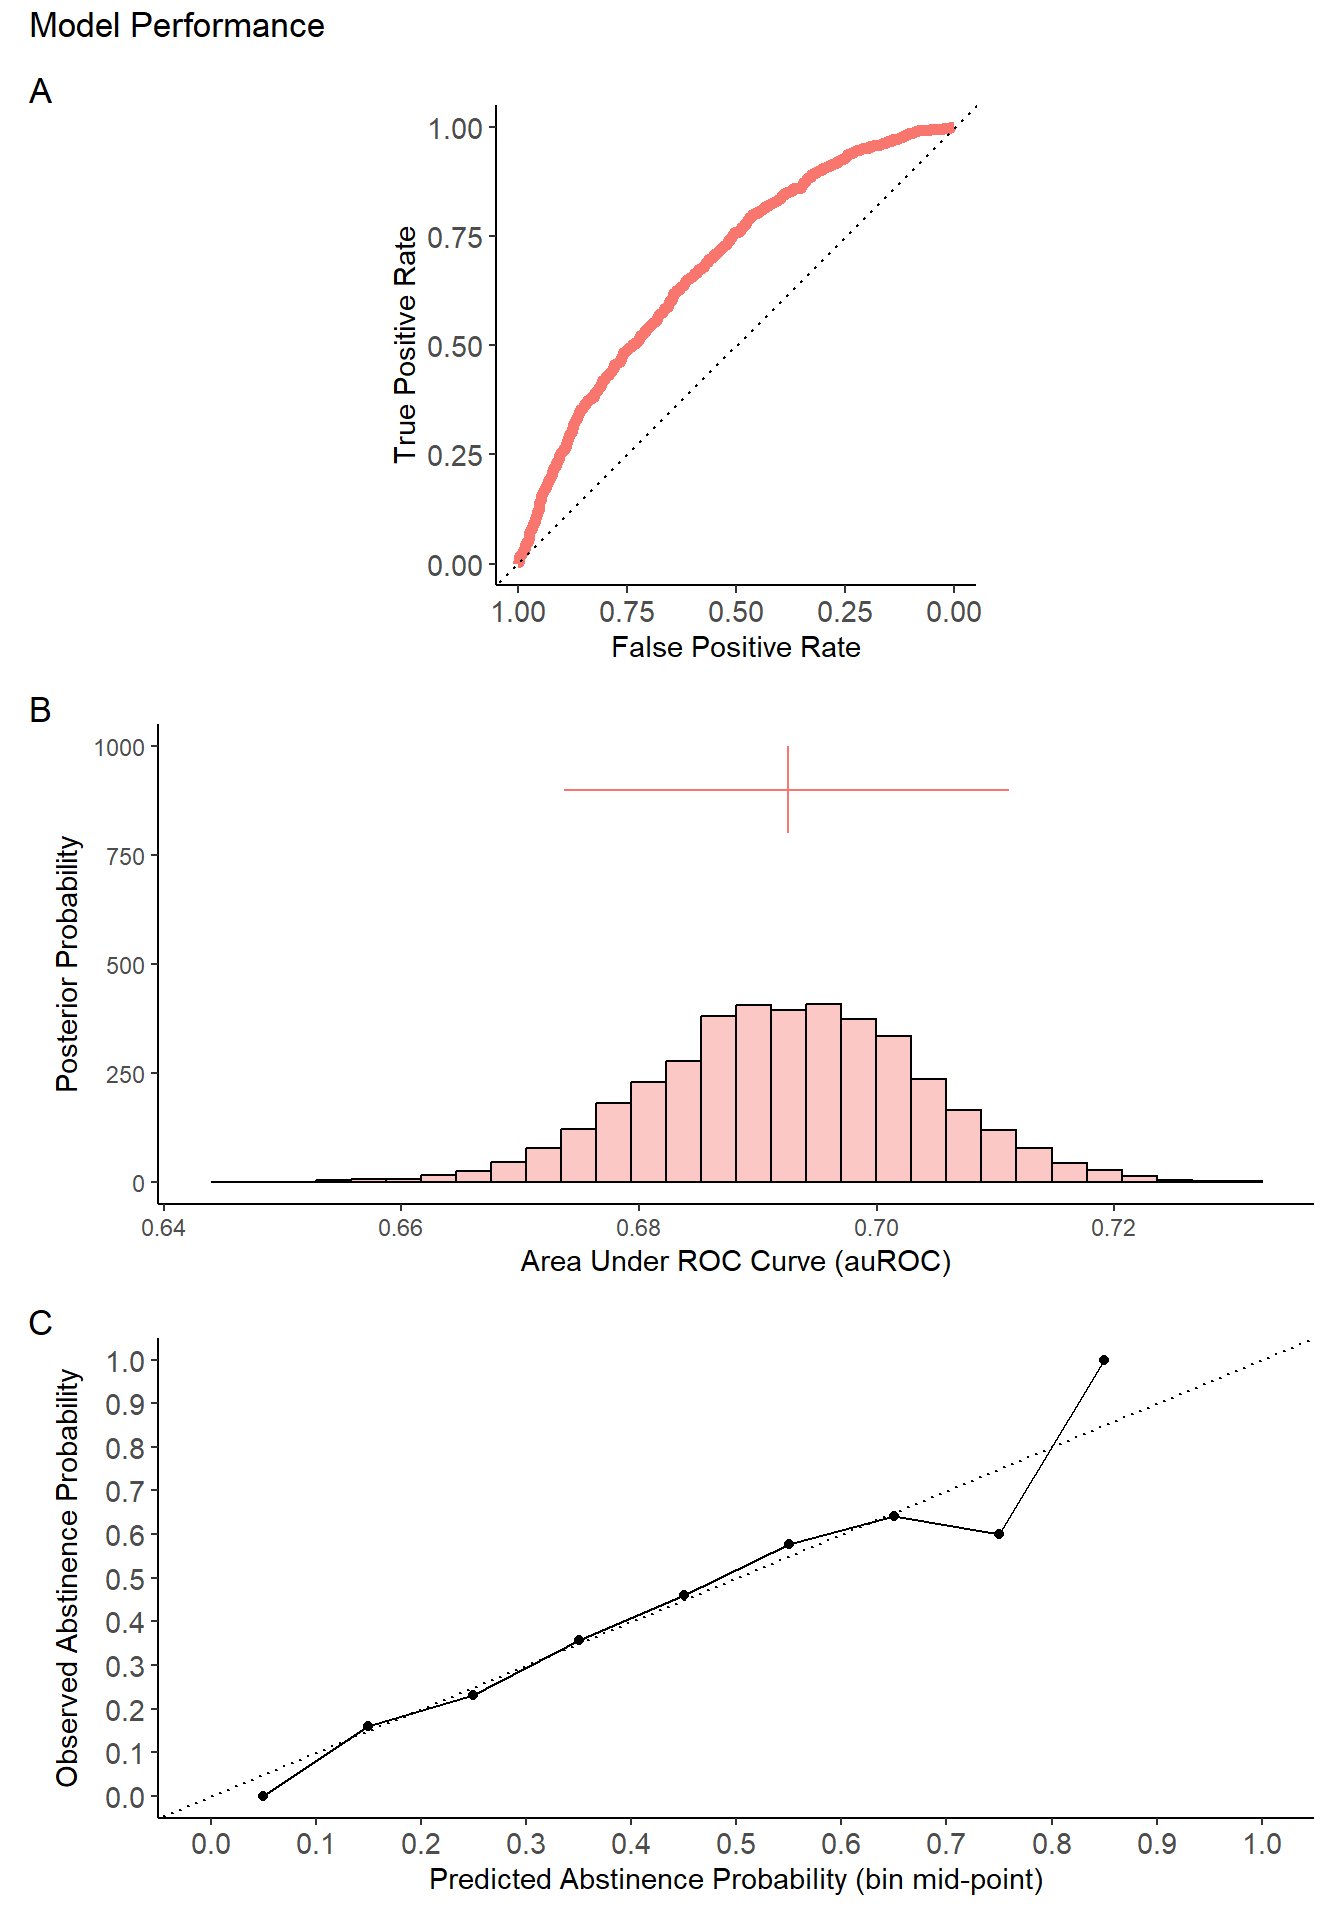

In [ ]:
#| label: fig-combined
#| fig-height: 10
#| fig-cap: "Model performance for prediction model. A) ROC curve plotted across all values of sensitivity (true positive rate) and specificity (1 - false positive rate). Dotted line indicates chance performance. B) Posterior probability distribution for the auROC. Histogram represents posterior probability distribution. Horizontal line displays 95% Bayesian credible interval. C) Model calibration between predicted probabilities and observed values. Predicted probabilities obtained via leave-one-out cross-validation for each participant for their RCT-assigned treatment. Dotted line indicates perfect calibration."

patchwork <- fig_roc + fig_pp + fig_cal_bins 

patchwork + plot_annotation(
  title = "Model Performance",
  tag_levels = c("A", "B", "C")
) +
  plot_layout(ncol = 1, heights = unit(c(2.5,2.5,2.5), 'in'))